# Import our dataset 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import percentile
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime
import matplotlib.dates as mdates
import operator
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from funcs import * 

Removed outlined from index  56 from  S1Temp with value of: 0.0
Removed outlined from index  1188 from  S3Temp with value of: -12.32
Removed outlined from index  3760 from  S1Light with value of: 5500
Removed outlined from index  2800 from  S3Light with value of: 65536


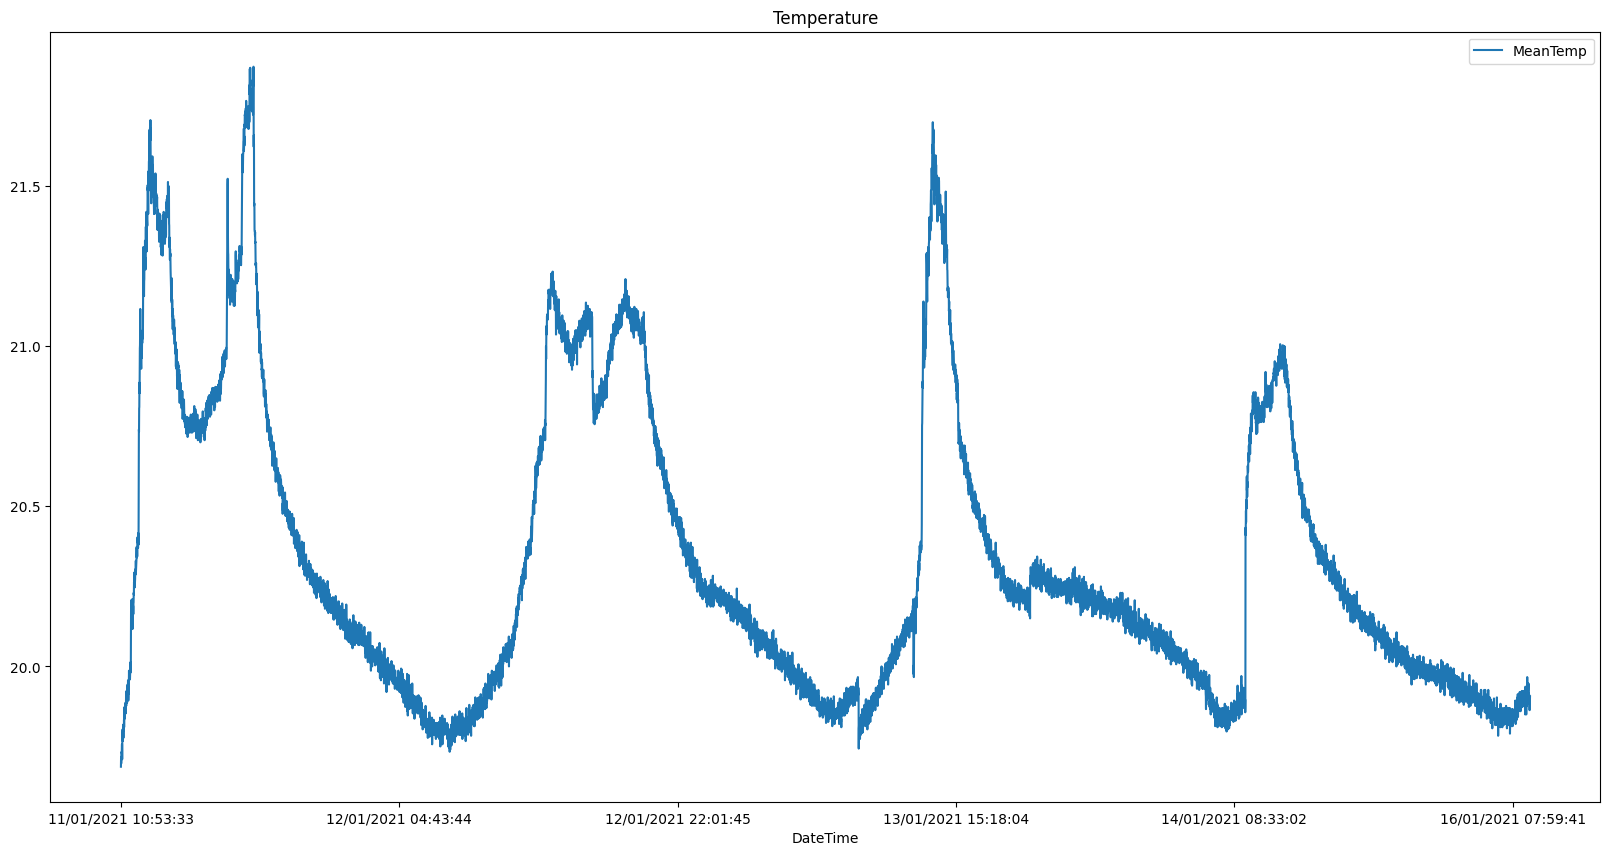

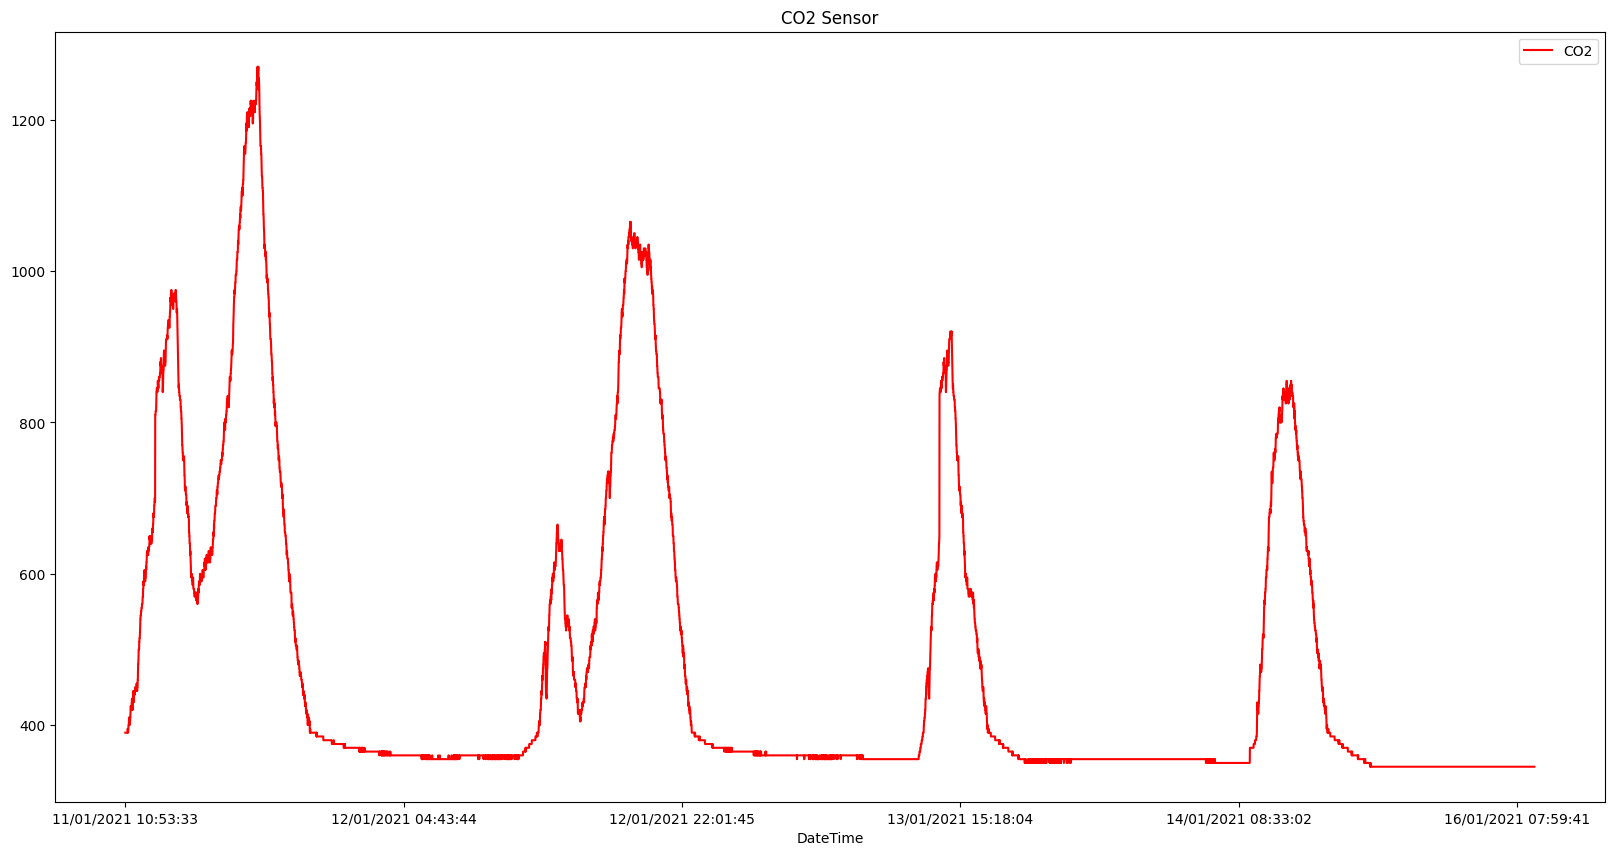

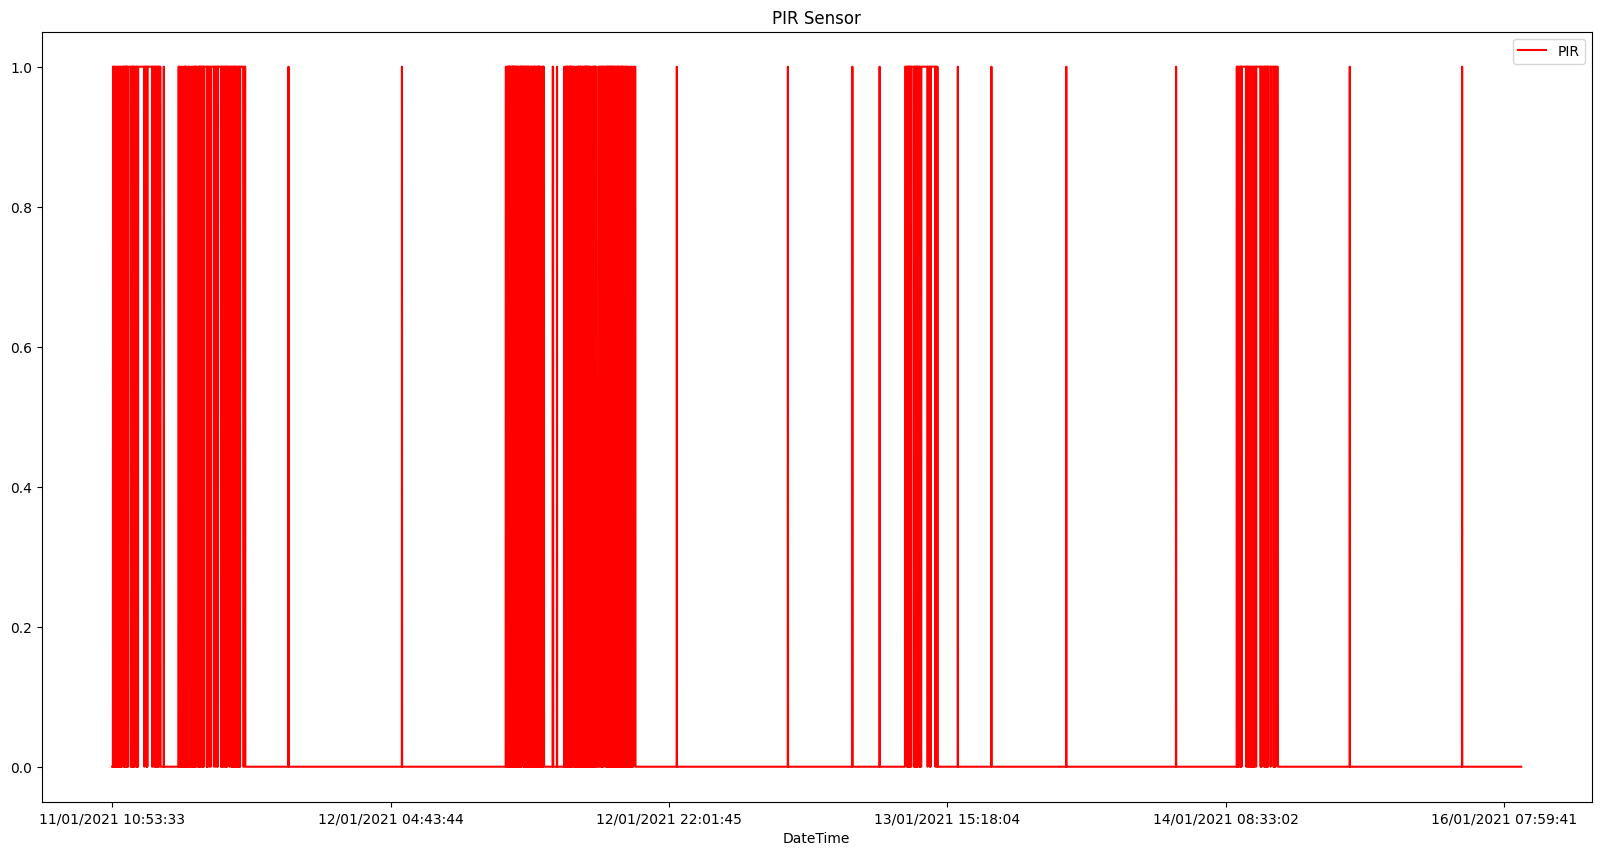

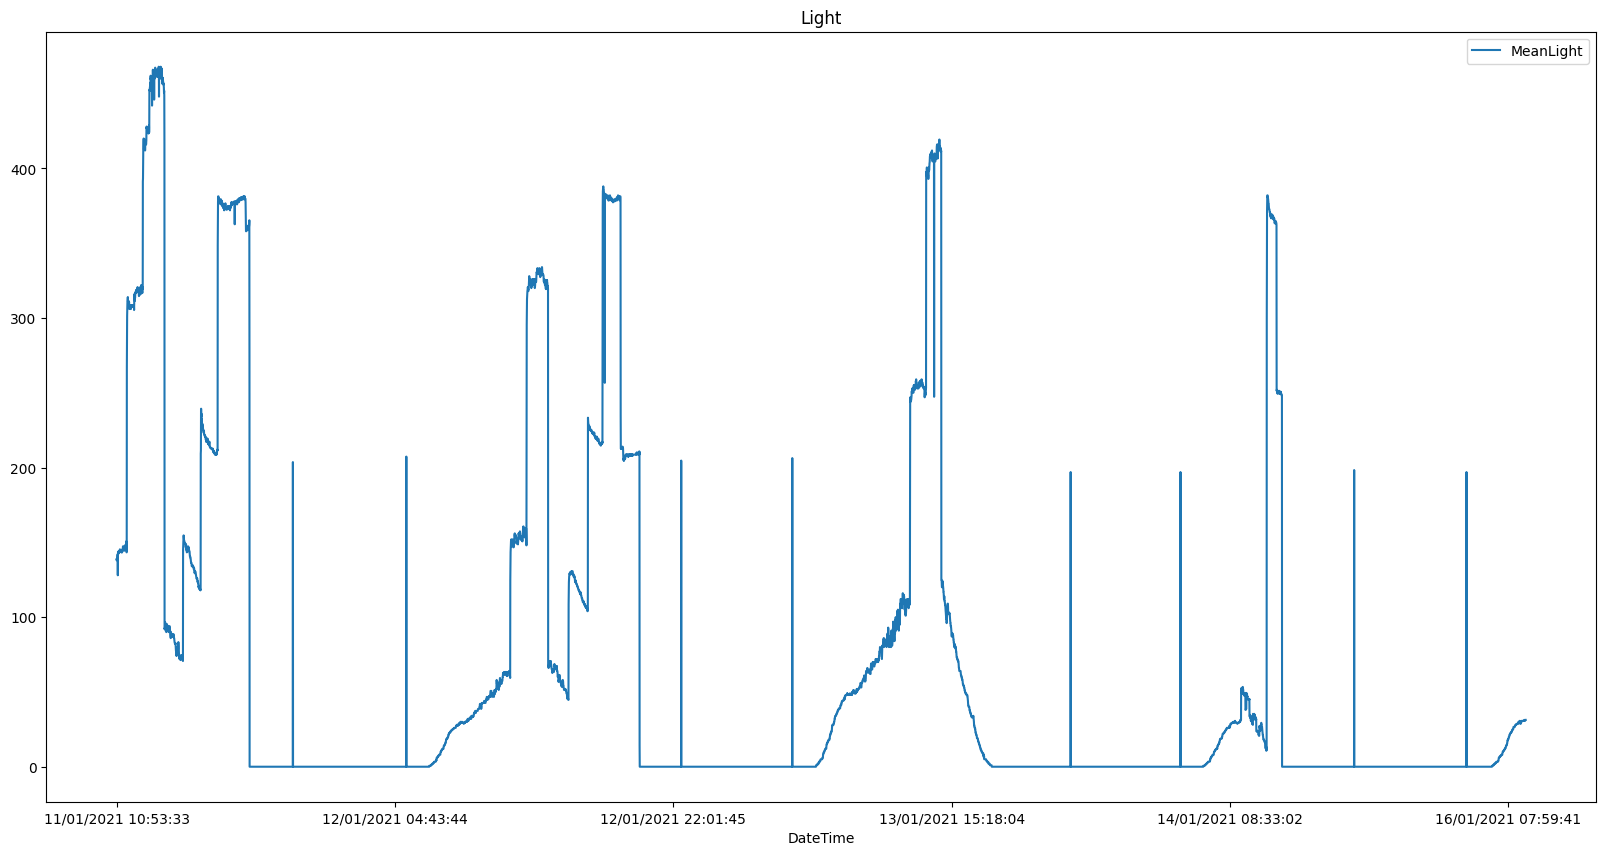

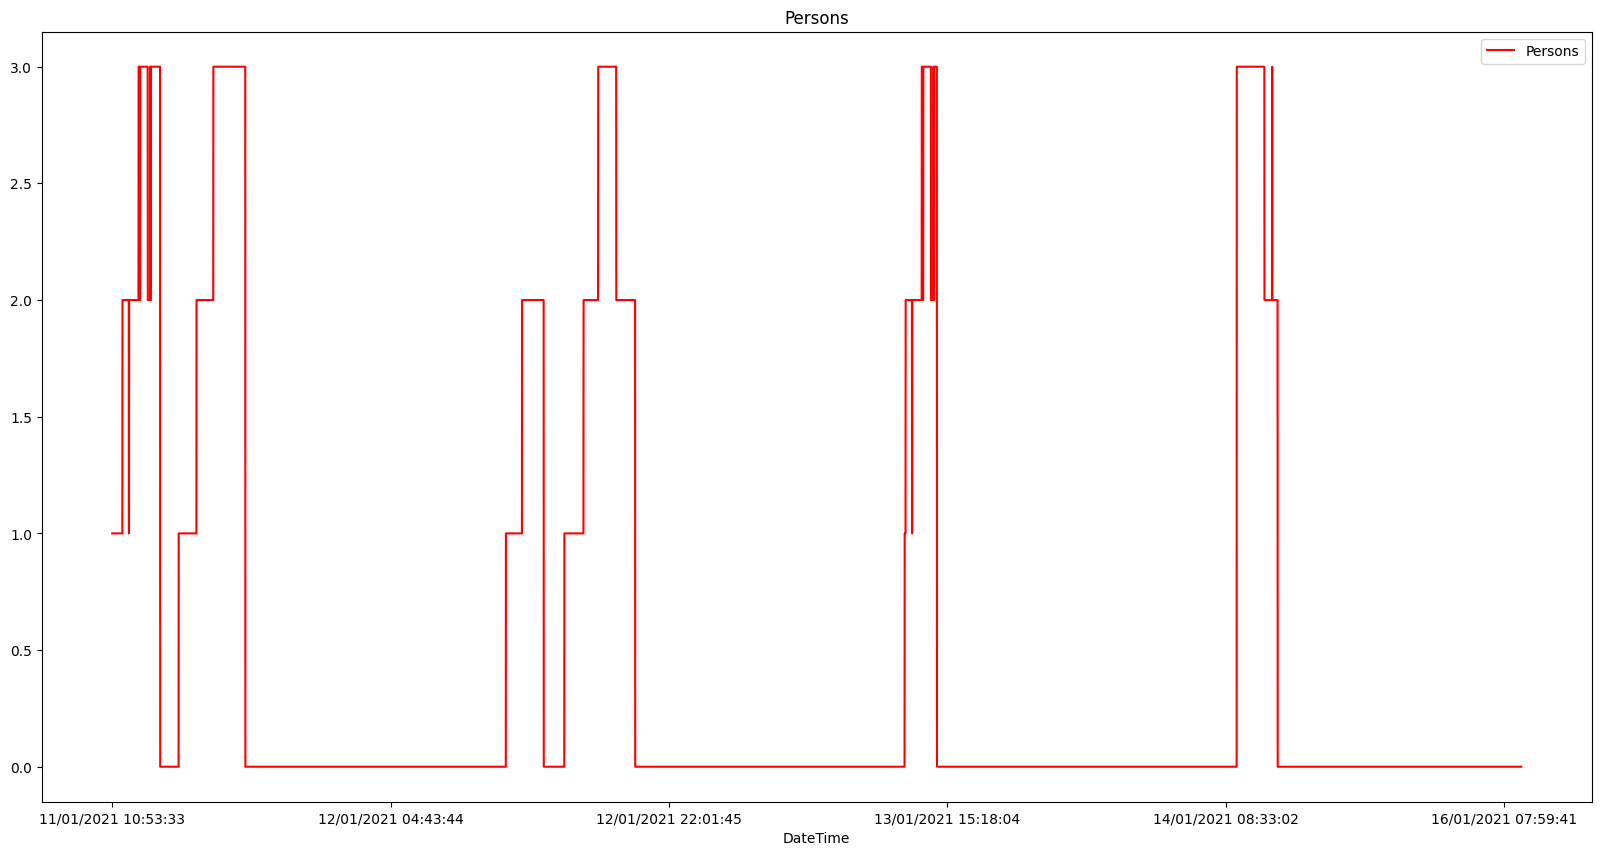

In [2]:



data_df = pd.read_csv('Proj1_Dataset.csv', sep=',', decimal='.')
data_df=parse_date_time(data_df)
data_df = drop_outliners(data_df, threshold=6,
                         collumn_to_remove_outliers=
                         ["S1Temp", "S2Temp","S3Temp",
                          "CO2","PIR1", "PIR2","S1Light",
                           "S2Light","S3Light"])
data_df = data_df.interpolate(method='linear', limit_direction='forward', axis=0)
#plot_data(data_df, temperature=True, CO2=True, PIR=True, light=True)

#group PIR1 and PIR2
data_df['PIR'] =(data_df['PIR1'] | data_df['PIR2'])
#data_df = data_df.drop(['PIR1', 'PIR2'], axis=1)

# iterate between indexes of collumn PIR

data_df["MeanTemp"] = data_df[["S1Temp", "S2Temp","S3Temp"]].mean(axis=1)
data_df["MeanLight"] = data_df[["S1Light", "S2Light","S3Light"]].mean(axis=1)

#data_df to csv
data_df.to_csv('data_df_fuzzy.csv', sep=',', decimal='.', index=False)


plot_data(data_df, temperature=True, Temp_join=True, CO2=True, PIR=False, PIR_Join = True, light=True, MeanLight=True, persons=True)





# Choose input and output variables

Inputs: "S1Temp", "S2Temp"
        ,"S3Temp","CO2",
        "PIR1", "PIR2",
        "S1Light","S2Light"
        ,"S3Light" 

Output: "Persons" 

/home/lima/.local/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


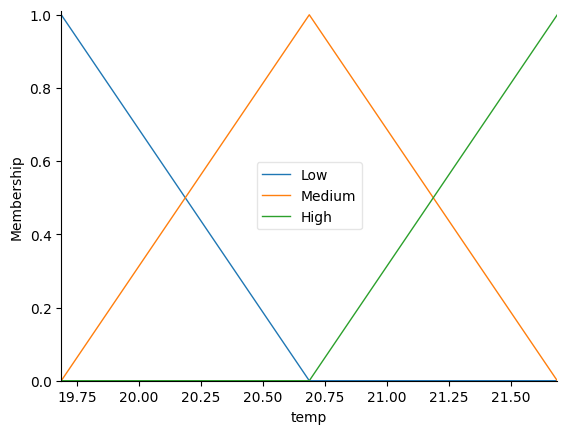

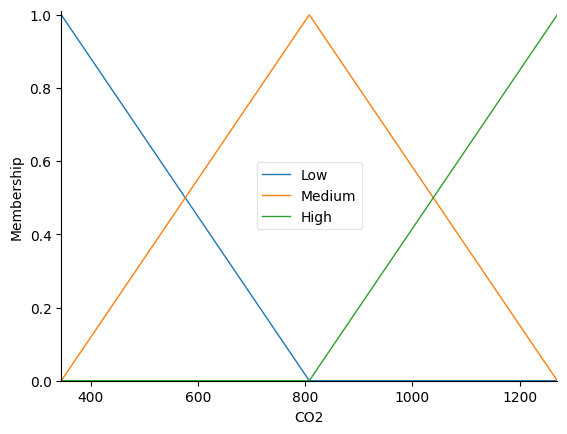

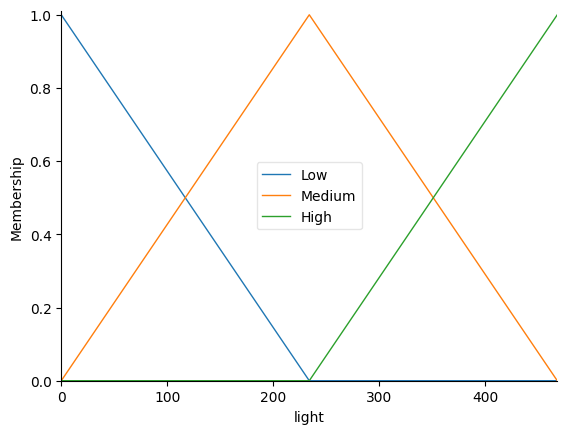

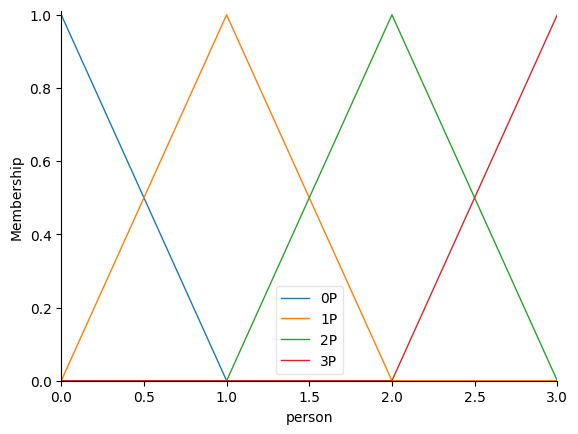

In [3]:


# Generate universe variables
#   * temperature subjective ranges [19, 24]
#   * CO2 subjective ranges [300, 1300]
#   * PIR subjective ranges [0, 1]
#   * light subjective ranges [0, 600]

x_temperature   = np.arange(data_df['MeanTemp'].min(), data_df['MeanTemp'].max(), 1)
x_CO2           = np.arange(data_df['CO2'].min(), data_df['CO2'].max()+1, 1)
x_light         = np.arange(data_df['MeanLight'].min(), data_df['MeanLight'].max()+1, 1)
y_person        = np.arange(data_df['Persons'].min(), data_df['Persons'].max() +1, 1)


temp    = ctrl.Antecedent(x_temperature, 'temp')
CO2     = ctrl.Antecedent(x_CO2, 'CO2')
light   = ctrl.Antecedent(x_light, 'light')
person  = ctrl.Consequent(y_person, 'person')

min = x_temperature.min()
max = x_temperature.max()
med = min+((max-min)/2)

temp['Low'] = fuzz.trimf(temp.universe, [min, min, med])
temp['Medium'] = fuzz.trimf(temp.universe, [min, med, max])
temp['High'] = fuzz.trimf(temp.universe, [med, max, max])

min = x_CO2.min()
max = x_CO2.max()
med = min+((max-min)/2)
CO2['Low'] = fuzz.trimf(CO2.universe, [min, min, med])
CO2['Medium'] = fuzz.trimf(CO2.universe, [min, med, max])
CO2['High'] = fuzz.trimf(CO2.universe, [med, max, max])

min = x_light.min()
max = x_light.max()
med = min+((max-min)/2)
light['Low'] = fuzz.trimf(light.universe, [min, min, med])
light['Medium'] = fuzz.trimf(light.universe, [min, med, max])
light['High'] = fuzz.trimf(light.universe, [med, max, max])


person['0P'] = fuzz.trimf(person.universe, [0,0, 1])
person['1P'] = fuzz.trimf(person.universe, [0,1,2])
person['2P'] = fuzz.trimf(person.universe, [1,2,3])
person['3P'] = fuzz.trimf(person.universe, [2,3,3])
temp.view()
CO2.view()
light.view()
person.view()





In [4]:
# Define rules

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score, f1_score, mean_absolute_error, mean_squared_error
r1  = ctrl.Rule(CO2['High'] & light['High'], person['3P'])
r2  = ctrl.Rule(CO2['High'] & light['Medium'], person['2P'])
r3  = ctrl.Rule(CO2['High'] & light['Low'] & temp['High'], person['1P']) 
r4  = ctrl.Rule(CO2['High'] & light['Low'] & (temp['Medium'] | temp['Low']), person['0P'])
r5  = ctrl.Rule(CO2['Medium'] & light['High'], person['2P'])
r6  = ctrl.Rule(CO2['Medium'] & light['Medium'] & temp['High'], person['3P'])
r7  = ctrl.Rule(CO2['Medium'] & light['Medium'] & temp['Medium'], person['2P'])
r8  = ctrl.Rule(CO2['Medium'] & light['Medium'] & temp['Low'], person['1P'])
r9  = ctrl.Rule(CO2['Medium'] & light['Low'], person['0P'])
r10 = ctrl.Rule(CO2['Low'] & light['High'], person['3P'])
r11 = ctrl.Rule(CO2['Low'] & light['Medium'], person['2P'])
r12 = ctrl.Rule(CO2['Low'] & light['Low'] & (temp['High']|temp['Medium']), person['1P'])
r13 = ctrl.Rule(CO2['Low'] & light['Low'] & temp['Low'], person['0P']) 

# add rules to control system
person_ctrl = ctrl.ControlSystem([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13])
# Create simulation
person_sim = ctrl.ControlSystemSimulation(person_ctrl)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
#person_sim.input['temp'] = 24

#import sys

y_pred = []
for row in data_df.iterrows():
    person_sim.input['temp'] = row[1]['MeanTemp']
    person_sim.input['CO2'] = row[1]['CO2']
    person_sim.input['light'] = row[1]['MeanLight']
    # Crunch the numbers
    person_sim.compute()
    
    y_pred.append(person_sim.output['person'].astype(int))
    

print(y_pred)
print("\n-------------------\n")
# y_pred to pandas dataframe
#y_pred = pd.DataFrame(y_pred)
y_real=data_df['Persons'].to_list()
print(y_real)


print("\n")
print("Accuracy:",accuracy_score(y_real, y_pred))
print("Precision:",precision_score(y_real, y_pred, average='macro'))
print("Recall:",recall_score(y_real, y_pred, average='macro'))
print("Confusion:\n",confusion_matrix(y_real, y_pred))    
print("\n")
#Defuzzify the output

# person_sim.input['CO2'] = 500
# person_sim.input['light'] = 1000
# person_sim.compute()
# print(person_sim.output['person'])



# # Plot the result
# person.view(sim=person_sim)
# plt.show()


    #person.view(sim=person_sim)


# Crunch the numbers


#print(person_sim.output['person'])
#person.view(sim=person_sim)



 

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

/home/lima/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Rule creation 



In [5]:
# min = x_temperature.min()
# max = x_temperature.max()
# med = min+((max-min)/2)

# # Generate fuzzy membership functions
# temperature_lo = fuzz.trimf(x_temperature , [min, min, med])
# temperature_md = fuzz.trimf(x_temperature , [min, med, max])
# temperature_hi = fuzz.trimf(x_temperature , [med, max, max])

# min = x_CO2.min()
# max = x_CO2.max()
# med = min+((max-min)/2)

# CO2_lo = fuzz.trimf(x_CO2 , [min, min, med])
# CO2_md = fuzz.trimf(x_CO2 , [min, med, max])
# CO2_hi = fuzz.trimf(x_CO2 , [med, max, max])


# min = x_light.min()
# max=x_light.max()
# med = min+((max-min)/2)
# light_lo = fuzz.trimf(x_light , [min, min, med])
# light_md = fuzz.trimf(x_light , [min, med, max])
# light_hi = fuzz.trimf(x_light , [med, max, max])

# min = y_person.min()
# max = y_person.max()
# med = min+((max-min)/2)
# person_lo = fuzz.trimf(y_person , [min, min, med])
# person_md = fuzz.trimf(y_person , [min, med, max])
# person_hi = fuzz.trimf(y_person , [med, max, max])

# # Visualize these universes and membership functions
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(20,10))

# ax0.plot(x_temperature, temperature_lo, 'b', linewidth=1.5, label='Low')
# ax0.plot(x_temperature, temperature_md, 'g', linewidth=1.5, label='Medium')
# ax0.plot(x_temperature, temperature_hi, 'r', linewidth=1.5, label='High')
# ax0.set_title('Temperature')
# ax0.legend()

# ax1.plot(x_CO2, CO2_lo, 'b', linewidth=1.5, label='Low')
# ax1.plot(x_CO2, CO2_md, 'g', linewidth=1.5, label='Medium')
# ax1.plot(x_CO2, CO2_hi, 'r', linewidth=1.5, label='High')
# ax1.set_title('CO2')
# ax1.legend()

# ax2.plot(x_light, light_lo, 'b', linewidth=1.5, label='Low')
# ax2.plot(x_light, light_md, 'g', linewidth=1.5, label='Medium')
# ax2.plot(x_light, light_hi, 'r', linewidth=1.5, label='High')
# ax2.set_title('Light')
# ax2.legend()

# ax3.plot(y_person, person_lo, 'b', linewidth=1.5, label='Empty')
# ax3.plot(y_person, person_md, 'g', linewidth=1.5, label='Normal')
# ax3.plot(y_person, person_hi, 'r', linewidth=1.5, label='Crowded')
# ax3.set_title('Person')
# ax3.legend()


# # Turn off top/right axes
# for ax in (ax0, ax1, ax2):
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.get_xaxis().tick_bottom()
#     ax.get_yaxis().tick_left()

# plt.tight_layout()

